In [1]:
from __future__ import print_function
import pyemma
pyemma.__version__

'2.4'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [54]:
import pandas as pd
import seaborn as sns

In [4]:
indir = '../Data/proc_traj'
topfile =  indir+'/2agy-as1.prmtop'
from glob import glob
traj_list = glob(indir+'/2agy-*-as1.nc')

In [5]:
import numpy as np
import pickle
high_dihed = np.load('../Common/high_variance_dihedrals_active_site.npy')
print(len(high_dihed))
all_dihed = pickle.load(open('../Common/2agy_as-1_dihedrals.pickl', 'rb'))
print(len(all_dihed))

34
159


In [6]:
# add_dihedrals(indexes, deg=False, cossin=False, periodic=True)
feat = coor.featurizer(topfile)
feat.add_dihedrals(indexes=high_dihed, cossin=True, periodic=True)
feat.dimension()


68

In [7]:
inp = coor.load(traj_list, feat)
# print('number of trajectories = ',inp.number_of_trajectories())
# print('trajectory length = ',inp.trajectory_length(0))
# print('trajectory time step = ',100 / (inp.trajectory_length(0)),'ns')
# print('number of dimension = ',inp.dimension())

In [8]:
dt = 0.01 # nanoseconds per frame
stride = 10 # frames per nanosecond

In [9]:
tica_lag = 55
tica_obj = coor.tica(inp, lag=int(tica_lag/dt), var_cutoff=0.95, kinetic_map=True, stride=stride)

In [10]:
Y = tica_obj.get_output()

In [11]:
n_dims = tica_obj.dimension()
print(n_dims)

3


### Cluster

In [12]:
n_trajs = len(inp)
n_frames = inp[0].shape[0]
n_trajs

100

In [13]:
n_clusters = int(np.sqrt(n_trajs*n_frames/stride))
n_clusters

316

In [14]:
clustering = coor.cluster_kmeans(Y,k=n_clusters, max_iter=100, stride=stride)


01-11-17 16:52:54 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 17 steps.


In [15]:
dtrajs = clustering.dtrajs

In [16]:
# dtrajs = [dtraj.flatten() for dtraj in dtrajs]
dtrajs[0].shape

(10000,)

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


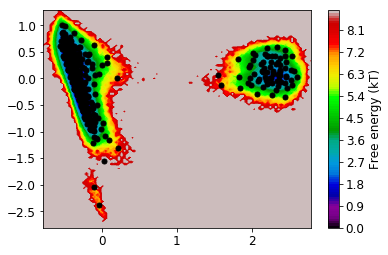

In [17]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

### Compare estimators and and sample size

In [64]:
msm_lag = int(50/dt)
samples = np.logspace(2,3, 5)
ts = []
method = []
nsamples = []
for n in samples:
    print(int(n))
    M = msm.BayesianMSM(lag=msm_lag, nsamples=int(n), count_mode='sliding')
    M.fit(dtrajs)
    
    tmp=M.sample_f('timescales', 1)
    tmp = [x[0] for x in tmp]
    ts.extend(tmp)
    method.extend(['sliding']*int(n))
    nsamples.extend([int(n)]*int(n))
#     method.append('sliding')
 

100
177
316
562
1000


In [65]:
for n in samples:
    print(int(n))
    M = msm.BayesianMSM(lag=msm_lag, nsamples=int(n), count_mode='effective')
    M.fit(dtrajs)
    
    tmp=M.sample_f('timescales', 1)
    tmp = [x[0] for x in tmp]
    ts.extend(tmp)
    method.extend(['effective']*int(n))
    nsamples.extend([int(n)]*int(n))
 

100
177
316
562
1000


In [66]:
for n in samples:
    print(int(n))
    M = msm.BayesianMSM(lag=msm_lag, nsamples=int(n), count_mode='sample')
    M.fit(dtrajs)
    
    tmp=M.sample_f('timescales', 1)
    tmp = [x[0] for x in tmp]
    ts.extend(tmp)
    method.extend(['sample']*int(n))
    nsamples.extend([int(n)]*int(n))
 

100


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


177


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


316


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


562


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


1000


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


In [72]:
(1000+562+316+177+100)*3


6465

In [70]:
len(ts)

6465

In [73]:
for met in ['sliding', 'effective', 'sample']:
    M = msm.MaximumLikelihoodMSM(lag=msm_lag, count_mode=met)
    M.fit(dtrajs)
    
    tmp = M.timescales(1)
    ts.extend(tmp)
    method.extend(['mle_'+met])
    nsamples.extend([1])


/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:545: SpectralWarning: Multiple eigenvalues with magnitude one.
  warnings.warn('Multiple eigenvalues with magnitude one.', SpectralWarning)


In [74]:
df = pd.DataFrame(data={'timescale': ts,  'method': method, 'nsamples': nsamples})

In [102]:
df['timescale'] *= dt

In [105]:
df.groupby(['method', 'nsamples']).aggregate([np.mean, np.std])['timescale']

mean       std
method        nsamples                      
effective     100       436.982893  5.011282
              177       436.280438  5.659207
              316       437.659059  5.465435
              562       436.812183  5.521922
              1000      436.793718  5.323713
mle_effective 1         436.445504       NaN
mle_sample    1                inf       NaN
mle_sliding   1         440.634247       NaN
sample        100              inf       NaN
              177              inf       NaN
              316              inf       NaN
              562              inf       NaN
              1000             inf       NaN
sliding       100       440.066943  4.503658
              177       440.902345  4.650504
              316       440.436323  4.992679
              562       441.054069  5.183777
              1000      441.063673  4.897239

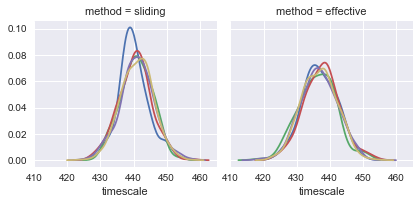

In [106]:
g = sns.FacetGrid(col='method', hue='nsamples', data =df.loc[df['method'].isin(['sliding', 'effective'])])
g.map(sns.distplot, 'timescale', hist=False)
